# 1.0 Data Wrangling

## Foundations of Spatial Data Science - CASA0013

### Group Project - Policy Brief

In [260]:
#Importing required packages
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 1.1 Calculating Rate of Professional AirBnB hosts by LSOA

### 1.1.1 Read in data

In [261]:
# Reading in listings data
listings = gpd.read_feather("data/2022-09-10-listings.geofeather")

In [262]:
#Reading in the Lower Super Output Area (LSOA) shapefile
lsoa = gpd.read_file("data/boundaries/LSOA_2004_London_Low_Resolution.shp")

### 1.1.2 Identify professional listings

In [263]:
#Converting the total_listing_count column to numpy array for manipulation
host_count = np.array(listings['host_total_listings_count'].values.tolist())

In [264]:
host_count[host_count > 1] = 0 #Changing any values above 1 to 0. Meaning "not casual" (professional).

In [265]:
listings['casual'] = host_count #Creating a new column which identifies if a listings host is casual (1 listing), or professional (>1 listing)


|  | Professional | Non-Professional (Casual)|
| --- | --- | --- |
| **Listing Count** | > 1 |1 |

### 1.1.3 Convert to same CRS

In [266]:
#LSOA is in the British National Grid (BNG) coordinate reference system.
listings = listings.to_crs(lsoa.crs)

### 1.1.4 Spatial Join listings to LSOAs (spatial aggregation unit)

In [267]:
#Spatially joining the LSOA to each listing
lsoa_ls = listings.sjoin(lsoa, predicate="within")

In [268]:
#Number of professional vs casual Airbnb hosts by LSOA
lsoa_ls["count"] = 1
professional_count = lsoa_ls.groupby(["LSOA_CODE", "casual"])["count"].sum().reset_index()
professional_count

,LSOA_CODE,casual,count
0,E01000001,0,10
1,E01000001,1,4
2,E01000002,0,4
3,E01000002,1,4
4,E01000003,0,13
...,...,...,...
7809,E01004763,1,43
7810,E01004764,0,256
7811,E01004764,1,31
7812,E01004765,0,107


In [269]:
host_lsoa = professional_count.groupby("LSOA_CODE")["count"].sum().reset_index() #Total number of hosts per LSOA

In [270]:
#Identifying hosts that are professional (more than one listing)
prop_count = professional_count[professional_count["casual"] ==0].rename(columns={"count":"professional_count"}).merge(host_lsoa.rename(columns={"count":"total_count"}), on="LSOA_CODE", how="right")

In [271]:
#Calculating the proportion of professional AirBnB hosts to total hosts per LSOA
prop_count["prop"] = prop_count["professional_count"] / prop_count["total_count"]

In [272]:
prop_count

,LSOA_CODE,casual,professional_count,total_count,prop
0,E01000001,0.0,10.0,14,0.714286
1,E01000002,0.0,4.0,8,0.500000
2,E01000003,0.0,13.0,19,0.684211
3,E01000004,0.0,210.0,257,0.817121
4,E01000005,0.0,100.0,120,0.833333
...,...,...,...,...,...
4394,E01004761,0.0,196.0,213,0.920188
4395,E01004762,0.0,85.0,95,0.894737
4396,E01004763,0.0,328.0,371,0.884097
4397,E01004764,0.0,256.0,287,0.891986


In [273]:
#Merging this proportion with the overall spatially referenced LSOA data
lsoa_prop = lsoa.merge(prop_count, how="left", on="LSOA_CODE")

In [274]:
#lsoa_prop
prop_count

,LSOA_CODE,casual,professional_count,total_count,prop
0,E01000001,0.0,10.0,14,0.714286
1,E01000002,0.0,4.0,8,0.500000
2,E01000003,0.0,13.0,19,0.684211
3,E01000004,0.0,210.0,257,0.817121
4,E01000005,0.0,100.0,120,0.833333
...,...,...,...,...,...
4394,E01004761,0.0,196.0,213,0.920188
4395,E01004762,0.0,85.0,95,0.894737
4396,E01004763,0.0,328.0,371,0.884097
4397,E01004764,0.0,256.0,287,0.891986


In [275]:
#Calculate the area of each LSOA in km2
lsoa_prop['area'] = lsoa_prop.geometry.area/1000

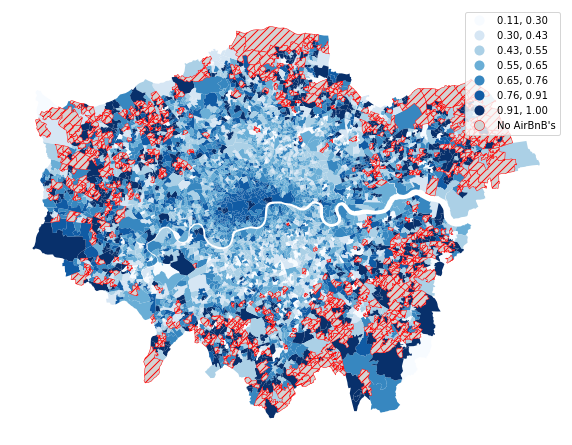

In [80]:
#An inital map identifying rates of professionalisation of AirBnB across London
fig, ax = plt.subplots(1, figsize=(10,10))

lsoa_prop.plot(column="prop", legend=True, ax=ax, k=7, scheme = "fisher_jenks", cmap="Blues",
               missing_kwds= dict(color = "lightgrey", label="No AirBnB's", edgecolor = "red", hatch= "///", linewidth=0.5))

plt.axis("off")

plt.savefig("figures/proportion_of_professional_hosts.png", dpi=300, facecolor="white", bbox_inches="tight")
plt.show()

## 1.3 Cultural Infrastructure
### 1.3.1 Read in data

In [291]:
#Import data
cultural = pd.read_csv('data/cultural-infrastructure-map-all-sites.csv')
print(f'Rows, Columns = {cultural.shape}')

#Clean column name
cultural.rename(columns = {'Cultural Venue Type':'venue_type'}, 
                   inplace = True)

# print(cultural.dtypes)
cultural.head(5)

Rows, Columns = (10003, 29)


,BOROUGH,venue_type,additional_contact_name,address1,address2,address3,alternativenames,borough_code,borough_name,building_name,...,rm_organisation_name,runtime,site_name,ward,ward_2018_code,ward_2018_name,ward_code,ward_code_2018,ward_name_2018,website
0,Tower Hamlets,Archives,NaN,Thomson Reuters,30 South Colonnade,Canary Wharf,NaN,E09000030,Tower Hamlets,NaN,...,NaN,04/20/2020,Reuters Archive,NaN,E05009323,Canary Wharf,NaN,NaN,NaN,https://reuters.screenocean.com/
1,Tower Hamlets,Archives,NaN,Whitechapel High Street,NaN,NaN,NaN,E09000030,Tower Hamlets,NaN,...,NaN,04/20/2020,Whitechapel Art Gallery,NaN,E05009333,Spitalfields & Banglatown,NaN,NaN,NaN,https://www.whitechapelgallery.org/
2,Tower Hamlets,Archives,NaN,37 Spital Square,NaN,NaN,NaN,E09000030,Tower Hamlets,NaN,...,NaN,04/20/2020,Society for the Protection of Ancient Buildings,NaN,E05009333,Spitalfields & Banglatown,NaN,NaN,NaN,https://www.spab.org.uk/
3,Tower Hamlets,Archives,NaN,Watson House,54 Baker Street,NaN,NaN,E09000030,Tower Hamlets,NaN,...,NaN,04/20/2020,Lasa,NaN,E05009333,Spitalfields & Banglatown,NaN,NaN,NaN,http://www.lasa.org.uk/
4,Tower Hamlets,Archives,NaN,Graces Alley,NaN,NaN,NaN,E09000030,Tower Hamlets,NaN,...,NaN,04/20/2020,Wilton's Music Hall,NaN,E05009336,Whitechapel,NaN,NaN,NaN,https://www.wiltons.org.uk/


In [292]:
#Convert to spatial object (geopandas)
gdf_cultural = gpd.GeoDataFrame(cultural, 
      geometry=gpd.points_from_xy(cultural.longitude, cultural.latitude, crs='epsg:4326'))

# Reproject to British National Grid
gdf_cultural = gdf_cultural.to_crs(lsoa.crs)
gdf_cultural.shape

(10003, 30)

In [293]:
#List of venue types
gdf_cultural.venue_type.unique()

array(['Archives', 'Artists workspaces', 'Arts centres', 'Cinemas',
       'Commercial galleries', 'Community centres',
       'Creative co-working desk space', 'Creative workspaces',
       'Dance performance venues', 'Dance rehearsal studios',
       'Fashion and design', 'Jewellery design',
       'Large media production studios', 'Legal street art walls',
       'LGBT+ night time venues', 'Libraries',
       "Live in artists' workspace", 'Makerspaces',
       'Making and manufacturing', 'Museums and public galleries',
       'Music (office based businesses)', 'Music recording studios',
       'Music rehearsal studios', 'Music venues (all)',
       'Music venues (grassroots)', 'Outdoor spaces for cultural use',
       'Prop and costume making', 'Pubs', 'Set and exhibition building',
       'Skate Parks', 'Textile design', 'Theatre rehearsal studio',
       'Theatres'], dtype=object)

### 1.3.3 Join points to LSOAs

In [294]:
#Spatially joining the LSOA to each cultural point
gdf_cultural = gdf_cultural.sjoin(lsoa, predicate="within")
gdf_cultural["count"] = 1

In [295]:
#Summarise by LSOA
count_by_lsoa = gdf_cultural.groupby('LSOA_CODE')['count'].sum().reset_index()

In [296]:
count_by_lsoa.head(5)

,LSOA_CODE,count
0,E01000001,12
1,E01000002,26
2,E01000003,4
3,E01000004,275
4,E01000005,22


### Reading in CEZ data

In [282]:
# Import libraries
import glob

# Get CSV files list from a folder
path = 'data/site_by_cez'
csv_files = glob.glob(path + "/*.csv")

# Read each CSV file into DataFrame
# This creates a list of dataframes
cez_list = (pd.read_csv(file) for file in csv_files)

# Concatenate all DataFrames
cez = pd.concat(cez_list, ignore_index=True)

cez.rename(columns = {'Cultural Venue Type':'venue_type', 'Creative Enterprise Zones': 'cez'}, 
                   inplace = True)


In [349]:
#Convert to spatial object (geopandas)
gdf_cez = gpd.GeoDataFrame(cez, 
      geometry=gpd.points_from_xy(cez.longitude, cez.latitude, crs='epsg:4326'))

# Reproject to British National Grid
gdf_cez = gdf_cez.to_crs(lsoa.crs)
gdf_cez.shape

(608, 18)

In [350]:
#Spatially joining the LSOA to each cultural point
gdf_cez = gdf_cez.sjoin(lsoa, predicate="within")
gdf_cez["clt_type"] = 'low'
gdf_cez.shape

(587, 28)

In [351]:
cultural_all = gdf_cultural.append(gdf_cez, ignore_index = True)
#cultural_all = pd.concat(gdf_cultural, gdf_cex, ignore_index = True)

/tmp/ipykernel_70493/3779546265.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cultural_all = gdf_cultural.append(gdf_cez, ignore_index = True)


### 1.3.2 Check for duplicates

Some venues are listed under multiple categories (e.g. pub and music venue); therefore need to limit each unique venue to a single observation.

In [352]:
# Identify list of duplicate sites
site_names = cultural_all["site_name"]
cultural_all[site_names.isin(site_names[site_names.duplicated()])].sort_values("cez")

,BOROUGH,venue_type,additional_contact_name,address1,address2,address3,alternativenames,borough_code,borough_name,building_name,...,LSOA_NAME,MSOA_CODE,MSOA_NAME,STWARDCODE,STWARDNAME,LA_CODE,LA_NAME,count,cez,clt_type
9988,NaN,Artists workspaces,NaN,"Park Royal, London",NaN,NaN,NaN,E09000009,Ealing,NaN,...,Ealing 015D,E02000252,Ealing 015,00AJGH,East Acton,00AJ,Ealing,NaN,Acton and Park Royal,low
9989,NaN,Creative workspaces,NaN,52-56 Standard Road,"Park Royal, London",NaN,NaN,E09000009,Ealing,NaN,...,Ealing 015D,E02000252,Ealing 015,00AJGH,East Acton,00AJ,Ealing,NaN,Acton and Park Royal,low
9990,NaN,Music rehearsal studios,NaN,Unit 1 Acorn Centre 30-34,Gorst Road,Ealing,NaN,E09000009,Ealing,NaN,...,Ealing 015D,E02000252,Ealing 015,00AJGH,East Acton,00AJ,Ealing,NaN,Acton and Park Royal,low
9991,NaN,Fashion and design,NaN,10B Cullen Way,NaN,NaN,NaN,E09000009,Ealing,NaN,...,Ealing 015E,E02000252,Ealing 015,00AJGH,East Acton,00AJ,Ealing,NaN,Acton and Park Royal,low
9992,NaN,Fashion and design,NaN,Suite 52 Park Royal Business Centre,9-17 Park Royal Road,NaN,NaN,E09000009,Ealing,NaN,...,Ealing 015E,E02000252,Ealing 015,00AJGH,East Acton,00AJ,Ealing,NaN,Acton and Park Royal,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9957,Croydon,Skate Parks,NaN,NaN,NaN,NaN,NaN,E09000008,Croydon,NaN,...,Croydon 037C,E02000230,Croydon 037,00AHGT,Purley,00AH,Croydon,1.0,NaN,NaN
9968,Bexley,Theatres,NaN,Lamorbey House,Burnt Oak Lane,NaN,NaN,E09000004,Bexley,NaN,...,Bexley 022E,E02000086,Bexley 022,00ADGW,Sidcup,00AD,Bexley,1.0,NaN,NaN
9973,Merton,Theatre rehearsal studio,NaN,Tolverne Road,Raynes Park,NaN,NaN,E09000024,Merton,NaN,...,Merton 010B,E02000698,Merton 010,00BAGM,Raynes Park,00BA,Merton,1.0,NaN,NaN
9974,Merton,Theatres,NaN,Tolverne Road,Raynes Park,NaN,NaN,E09000024,Merton,NaN,...,Merton 010B,E02000698,Merton 010,00BAGM,Raynes Park,00BA,Merton,1.0,NaN,NaN


In [353]:
# 4,099 duplicate observations identified
cultural_all.sort_values("cez").drop_duplicates(subset = "site_name", keep = 'first', inplace = True, ignore_index = True)
cultural_all.shape

(10575, 42)

### 1.3.X Cultural Infra Classification

In [356]:
#Remove irrelavant cultural points
values = ['Community centres', 'Pubs', 'Large media production studios', 'Libraries', 'Music (office based businesses)']

cultural_clean = cultural_all[cultural_all.venue_type.isin(values) == False]
cultural_clean.shape

(4673, 42)

Reduced df from 10575 to 4673.

In [357]:
#Classification
low = ['Arts centres', 'Cinemas', 'Creative co-working desk space', 'Creative workspaces',
       'Legal street art walls', 'LGBT+ night time venues', 'Live in artists’ workspace',
       'Makerspaces', 'Making and manufacturing', 'Music recording studios', 'Music rehearsal studios',
       'Artists workspaces', 'Dance rehearsal studios', 'Music venues (grassroots)', 'Prop and costume making',
       'Set and exhibition building', 'Skate Parks', 'Textile design', 'Theatre rehearsal studio',
       'Fashion and design', 'Jewellery design', 'Archives']

high = ['Commercial galleries', 'Museums and public galleries', 'Theatres', 'Dance performance venues',
        'Music venues (all)']

#cultural_clean['clt_type'] = cultural_clean['clt_type']


/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Cultural Infrastructure Data now complete.

In [335]:
#Merge sum per LSOA back with the overall spatially referenced LSOA data
lsoa_clt = lsoa_prop.merge(count_by_lsoa, how="left", on="LSOA_CODE")

#Calculating density of cultural points over LSOA Area
lsoa_clt['clt_density'] = lsoa_clt['count'] / lsoa_clt['area']

(500655.06033394457, 564875.8132172046, 154258.35576021337, 203156.24388533537)

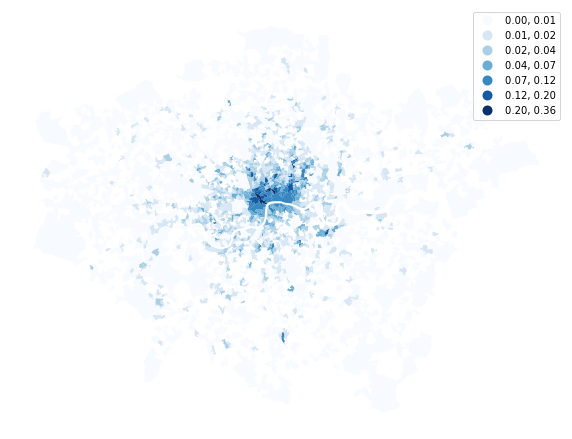

In [90]:
# Mapping density of cultural venues per LSOA
fig, ax = plt.subplots(1, figsize=(10,10))

lsoa_clt.plot(column="clt_density", legend=True, ax=ax, k=7, scheme = "fisher_jenks", cmap="Blues"
              # , missing_kwds= dict(color = "lightgrey", label="No AirBnB's", edgecolor = "red", hatch= "///", linewidth=0.5)
             )
plt.axis("off")

(500655.06033394457, 564875.8132172046, 154258.35576021337, 203156.24388533537)

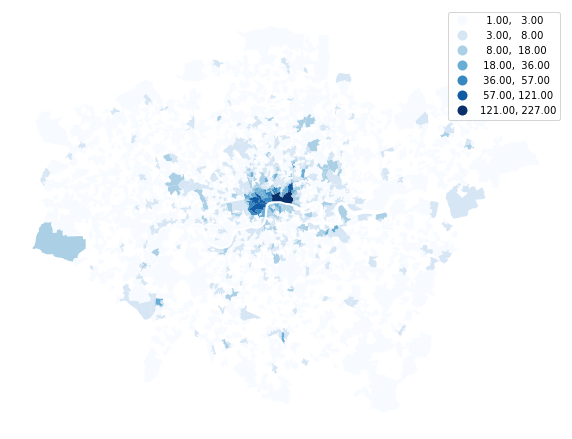

In [91]:
#An inital map identifying rates of professionalisation of AirBnB across London
fig, ax = plt.subplots(1, figsize=(10,10))

lsoa_clt.plot(column="count", legend=True, ax=ax, k=7, scheme = "fisher_jenks", cmap="Blues"
              # , missing_kwds= dict(color = "lightgrey", label="No AirBnB's", edgecolor = "red", hatch= "///", linewidth=0.5)
             )

plt.axis("off")

# plt.savefig("figures/proportion_of_professional_hosts.png", dpi=300, facecolor="white", bbox_inches="tight")
# plt.show()

In [92]:
lsoa_clt

,LSOA_CODE,LSOA_NAME,MSOA_CODE,MSOA_NAME,STWARDCODE,STWARDNAME,LA_CODE,LA_NAME,geometry,casual,professional_count,total_count,prop,area,count,clt_density
0,E01000001,City of London 001A,E02000001,City of London 001,00AAFA,Aldersgate,00AA,City of London,"POLYGON ((532050.879 181817.674, 532021.188 18...",0.0,10.0,14.0,0.714286,133.195257,11.0,0.082586
1,E01000002,City of London 001B,E02000001,City of London 001,00AAFQ,Cripplegate,00AA,City of London,"POLYGON ((532267.748 181643.784, 532254.565 18...",0.0,4.0,8.0,0.500000,225.826619,21.0,0.092992
2,E01000003,City of London 001C,E02000001,City of London 001,00AAFQ,Cripplegate,00AA,City of London,"POLYGON ((532071.310 182159.597, 532135.127 18...",0.0,13.0,19.0,0.684211,58.276984,3.0,0.051478
3,E01000004,City of London 001D,E02000001,City of London 001,00AAFT,Farringdon Without,00AA,City of London,"POLYGON ((531172.252 181124.643, 531133.747 18...",0.0,210.0,257.0,0.817121,2297.740070,227.0,0.098793
4,E01000005,City of London 001E,E02000001,City of London 001,00AAFX,Portsoken,00AA,City of London,"POLYGON ((533378.878 181459.767, 533439.561 18...",0.0,100.0,120.0,0.833333,192.719403,17.0,0.088211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4760,E01004761,Westminster 018D,E02000977,Westminster 018,00BKGW,West End,00BK,Westminster,"POLYGON ((528459.247 180541.840, 528440.441 18...",0.0,196.0,213.0,0.920188,518.541144,40.0,0.077139
4761,E01004762,Westminster 011E,E02000970,Westminster 011,00BKGW,West End,00BK,Westminster,"POLYGON ((528043.878 180619.098, 527888.747 18...",0.0,85.0,95.0,0.894737,295.520971,10.0,0.033839
4762,E01004763,Westminster 013B,E02000972,Westminster 013,00BKGW,West End,00BK,Westminster,"MULTIPOLYGON (((529156.425 181706.116, 529157....",0.0,328.0,371.0,0.884097,292.141711,92.0,0.314916
4763,E01004764,Westminster 013C,E02000972,Westminster 013,00BKGW,West End,00BK,Westminster,"POLYGON ((528561.997 181004.997, 528464.129 18...",0.0,256.0,287.0,0.891986,624.734704,121.0,0.193682


## 1.2 Gentrification Classifications (Yee and Dennett, 2020)

This is just a simple binary classification of areas that are predicted to gentrify vs areas that are not.

In [ ]:
#Import data
gent = pd.read_csv('data/predictions_modelling1.csv')
print(f'Rows, Columns = {gent.shape}')
print(gent.dtypes)

Rows, Columns = (4835, 5)
Unnamed: 0         int64
LSOA_Code         object
Class_1_status    object
Class_2_status    object
Class_3_status    object
dtype: object


In [95]:
lsoa_clt_gent = lsoa_clt.merge(gent[['LSOA11CD', 'predictions']], how = "left", left_on = "LSOA_CODE", right_on = "LSOA11CD")

(500655.06033394457, 564875.8132172046, 153596.66716660303, 203187.7528659835)

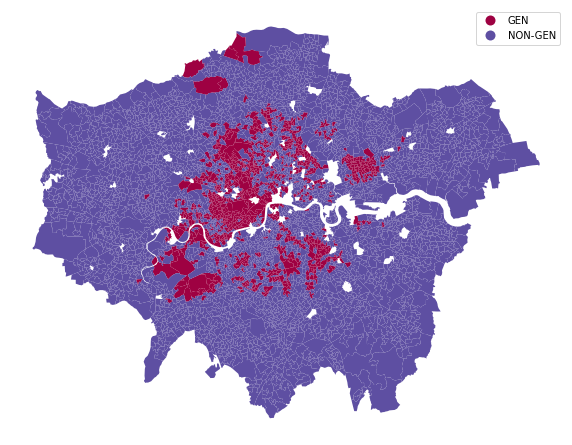

In [96]:
#Quick map showing gentrifying/non-gentrifying LSOAs
fig, ax = plt.subplots(1, figsize=(10,10))

lsoa_clt_gent.plot(column="predictions", categorical = True, legend=True, ax=ax, cmap="Spectral")

plt.axis("off")

This is a more stratified classification of areas that are gentrifying and how

In [124]:
#Import data
gent_strat = pd.read_csv('data/LSOA_labels_forMapping.csv')
print(f'Rows, Columns = {gent_strat.shape}')
print(gent_strat.dtypes)

Rows, Columns = (4835, 5)
Unnamed: 0         int64
LSOA_Code         object
Class_1_status    object
Class_2_status    object
Class_3_status    object
dtype: object


In [126]:
lsoa_strat_gent = lsoa_clt.merge(gent_strat, how = "left", left_on = "LSOA_CODE", right_on = "LSOA_Code")

(500655.06033394457, 564875.8132172046, 153596.66716660303, 203187.7528659835)

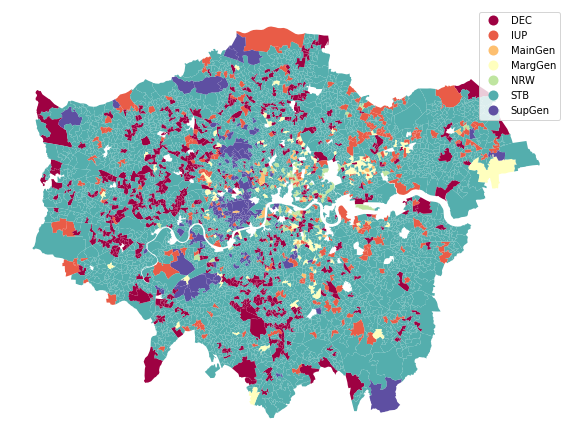

In [128]:
#Quick map showing gentrifying/non-gentrifying LSOAs
fig, ax = plt.subplots(1, figsize=(10,10))

lsoa_strat_gent.plot(column="Class_3_status", categorical = True, legend=True, ax=ax, cmap="Spectral")

plt.axis("off")

## 1.2.2 Start of logistic regression
Beginnings of logistic regression

In [103]:
lsoa_dummies = lsoa_clt_gent.merge(pd.get_dummies(lsoa_clt_gent[['predictions']]), left_index = True, right_index = True, how = "left")
lsoa_dummies

,LSOA_CODE,LSOA_NAME,MSOA_CODE,MSOA_NAME,STWARDCODE,STWARDNAME,LA_CODE,LA_NAME,geometry,casual,professional_count,total_count,prop,area,count,clt_density,LSOA11CD,predictions,predictions_GEN,predictions_NON-GEN
0,E01000001,City of London 001A,E02000001,City of London 001,00AAFA,Aldersgate,00AA,City of London,"POLYGON ((532050.879 181817.674, 532021.188 18...",0.0,10.0,14.0,0.714286,133.195257,11.0,0.082586,E01000001,GEN,1,0
1,E01000002,City of London 001B,E02000001,City of London 001,00AAFQ,Cripplegate,00AA,City of London,"POLYGON ((532267.748 181643.784, 532254.565 18...",0.0,4.0,8.0,0.500000,225.826619,21.0,0.092992,E01000002,NON-GEN,0,1
2,E01000003,City of London 001C,E02000001,City of London 001,00AAFQ,Cripplegate,00AA,City of London,"POLYGON ((532071.310 182159.597, 532135.127 18...",0.0,13.0,19.0,0.684211,58.276984,3.0,0.051478,E01000003,NON-GEN,0,1
3,E01000004,City of London 001D,E02000001,City of London 001,00AAFT,Farringdon Without,00AA,City of London,"POLYGON ((531172.252 181124.643, 531133.747 18...",0.0,210.0,257.0,0.817121,2297.740070,227.0,0.098793,NaN,NaN,0,0
4,E01000005,City of London 001E,E02000001,City of London 001,00AAFX,Portsoken,00AA,City of London,"POLYGON ((533378.878 181459.767, 533439.561 18...",0.0,100.0,120.0,0.833333,192.719403,17.0,0.088211,E01000005,NON-GEN,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4760,E01004761,Westminster 018D,E02000977,Westminster 018,00BKGW,West End,00BK,Westminster,"POLYGON ((528459.247 180541.840, 528440.441 18...",0.0,196.0,213.0,0.920188,518.541144,40.0,0.077139,E01004761,GEN,1,0
4761,E01004762,Westminster 011E,E02000970,Westminster 011,00BKGW,West End,00BK,Westminster,"POLYGON ((528043.878 180619.098, 527888.747 18...",0.0,85.0,95.0,0.894737,295.520971,10.0,0.033839,E01004762,GEN,1,0
4762,E01004763,Westminster 013B,E02000972,Westminster 013,00BKGW,West End,00BK,Westminster,"MULTIPOLYGON (((529156.425 181706.116, 529157....",0.0,328.0,371.0,0.884097,292.141711,92.0,0.314916,E01004763,GEN,1,0
4763,E01004764,Westminster 013C,E02000972,Westminster 013,00BKGW,West End,00BK,Westminster,"POLYGON ((528561.997 181004.997, 528464.129 18...",0.0,256.0,287.0,0.891986,624.734704,121.0,0.193682,NaN,NaN,0,0


In [107]:
from sklearn import linear_model
lsoa_dummies = lsoa_dummies.dropna()
X = np.array(lsoa_dummies['prop']).reshape(-1, 1)
y = np.array(lsoa_dummies['predictions_GEN'])
logr = linear_model.LogisticRegression()
logr.fit(X,y)


LogisticRegression()

<AxesSubplot:xlabel='prop', ylabel='Density'>

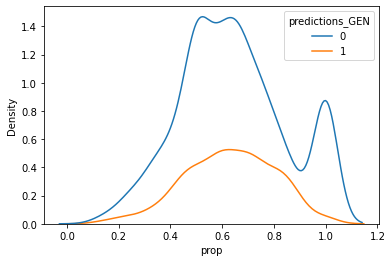

In [122]:
sns.kdeplot(data = lsoa_dummies, hue = 'predictions_GEN', x = 'prop')

In [116]:
log_odds = logr.coef_
odds = np.exp(log_odds)

print(odds)

[[0.73635697]]
